In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta
from scipy.ndimage import binary_dilation

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import espra, smooth, robust_smooth, tangential_velocity, fit_psi_params, psi_params


### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


(np.float64(-503632.91714574234),
 np.float64(363491.5836790992),
 np.float64(-499500.0000000002),
 np.float64(477299.9999999998))

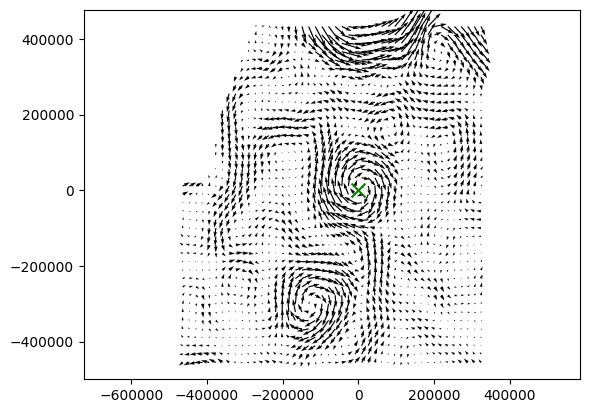

In [3]:
t_idx = 0
dic = dic_ssh_data[list(dic_ssh_data.keys())[t_idx]]
ut, vt = dic['u'], dic['v']
plt.quiver(x_ssh, y_ssh, ut, vt)
plt.scatter(0,0, marker='x', color='g', s=100)
plt.axis('equal')


/scratch/pbs.7071961.kman.restech.unsw.edu.au/ipykernel_1270061/1488636819.py:13: RuntimeWarning: invalid value encountered in sqrt
  rho_search = np.sqrt(q11_pre*dx**2 + 2*q12_pre*dx*dy + q22_pre*dy**2)


,xc,yc,w,Q,Rc,psi0,A,Time
0,3844.432520,5309.443027,-0.000027,"[[1.1501845463568723, 0.017300724757005077], [...",96434.814310,70322.726083,-0.000008,2023-10-18 18:00:00
1,4028.598606,6972.204595,-0.000027,"[[1.2378275192923252, 0.023327659822904585], [...",90258.113963,62897.012499,-0.000008,2023-10-19 18:00:00
2,4681.289277,6594.580785,-0.000029,"[[1.2612861582461656, 0.058724965753571515], [...",89716.678167,65168.617495,-0.000008,2023-10-20 18:00:00
3,2739.151927,8319.650798,-0.000028,"[[1.2387353809526243, 0.021655792499544215], [...",87457.815245,61838.754880,-0.000008,2023-10-21 18:00:00
4,1703.742792,8538.064814,-0.000026,"[[1.2294191619263521, 0.040962834132780054], [...",92502.971439,61828.368613,-0.000007,2023-10-22 18:00:00
...,...,...,...,...,...,...,...,...
113,-320982.739683,112616.982190,-0.000017,"[[1.86289582305675, -0.14197917492743228], [-0...",94656.890187,36040.314040,-0.000004,2024-02-04 06:00:00
114,-327113.425541,109345.437259,-0.000014,"[[2.035480441554206, -0.15444816339197331], [-...",109173.915901,37140.121616,-0.000003,2024-02-05 06:00:00
115,-329127.567714,100920.448426,-0.000008,"[[2.3533676994610513, -0.024034089676106093], ...",120450.863992,30870.552921,-0.000002,2024-02-06 06:00:00
116,-322125.926819,131527.067491,-0.000010,"[[1.9886299490910664, -0.3108610148420783], [-...",184710.677799,66194.839429,-0.000002,2024-02-07 06:00:00


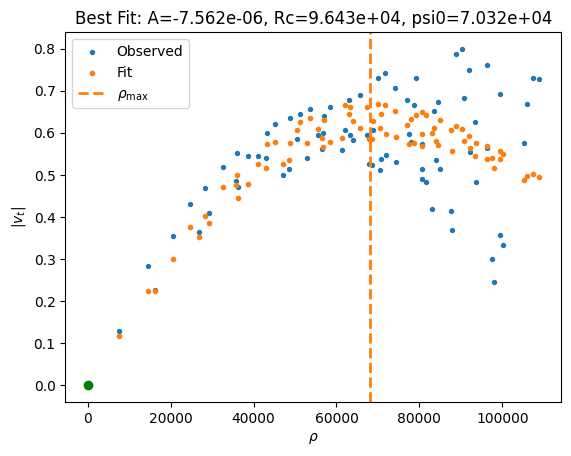

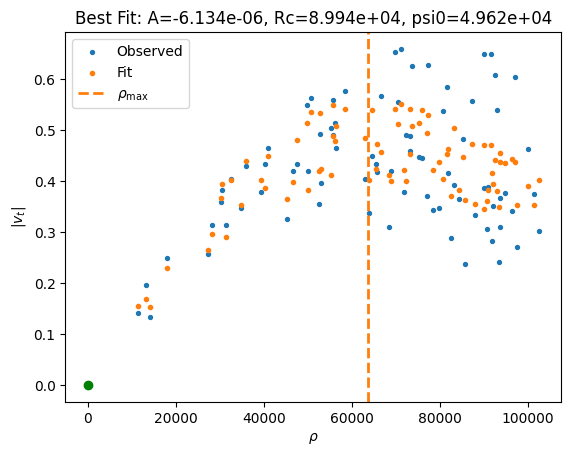

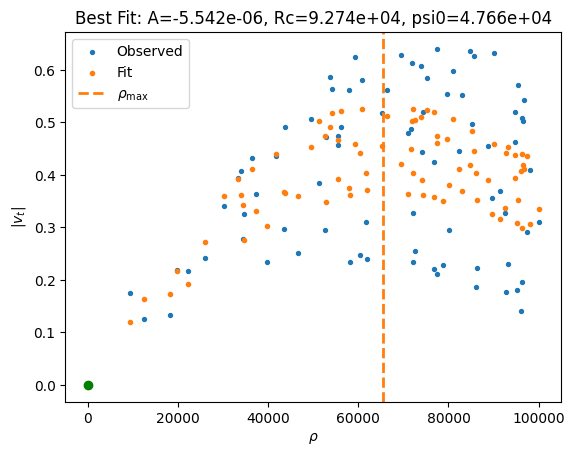

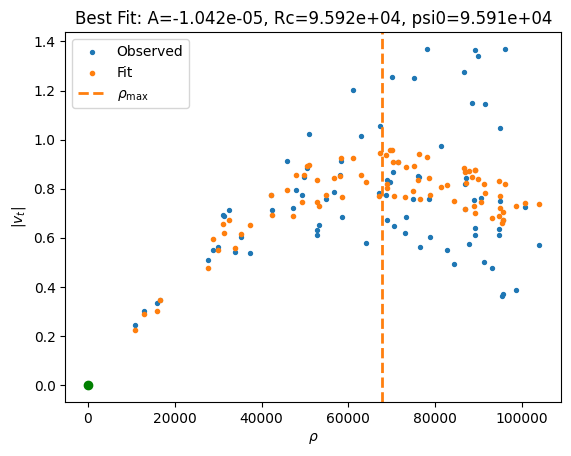

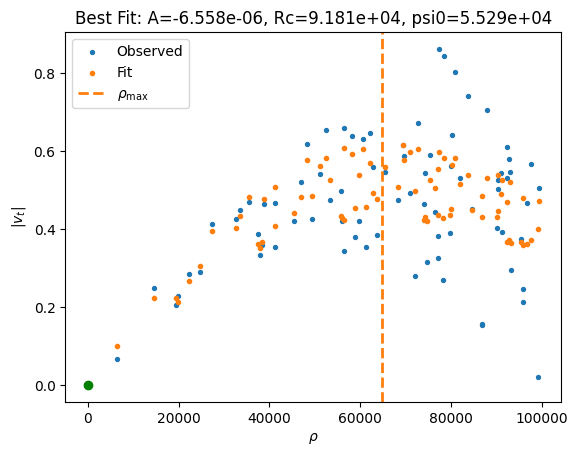

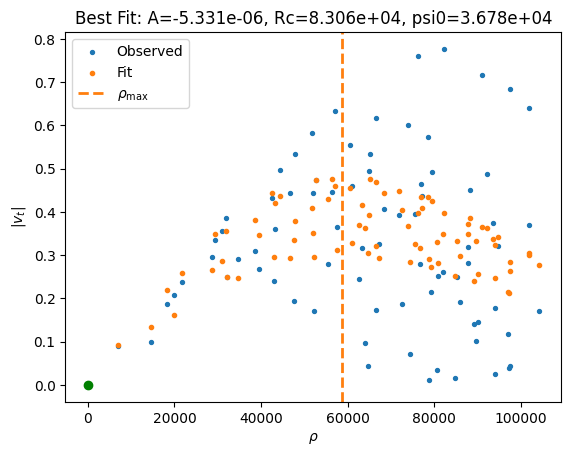

In [4]:
xc_pre, yc_pre = 0, 0
q11_pre, q12_pre, q22_pre = 1, 0, 1
df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'Time'])
rho_core_thresh = 50000
rho_outer_core_thresh = 100000
dic_params = {}
for k, t_idx in enumerate(range(len(dic_ssh_data))):
    time = list(dic_ssh_data.keys())[t_idx]
    dic = dic_ssh_data[time]
    ut, vt = dic['u'], dic['v']

    dx, dy = x_ssh - xc_pre, y_ssh - yc_pre
    rho_search = np.sqrt(q11_pre*dx**2 + 2*q12_pre*dx*dy + q22_pre*dy**2)
    mask_core = rho_search < rho_core_thresh
    xi, yi, ui, vi = x_ssh[mask_core], y_ssh[mask_core], ut[mask_core], vt[mask_core]
    xc, yc, w, Q, _, _, A0 = espra(xi, yi, ui, vi, Rc_max=150000)
    # All
    mask_outer = rho_search < rho_outer_core_thresh
    axi, ayi, aui, avi = x_ssh[mask_outer], y_ssh[mask_outer], ut[mask_outer], vt[mask_outer]

    if (np.hypot(xc-xc_pre, yc-yc_pre)<100000) & (np.sign(w)<0):

        df = psi_params(xc, yc, Q, axi, ayi, aui, avi)
        df = df[df.vt < 0]
        Rc, psi0, A = fit_psi_params(df.rho2, df.Qr, df.vt, A0=A0, Rc_max=150000, plot=True if k%20==0 else False)     
        
        if A >= 0:
            Rc, psi0, A = np.nan, np.nan, np.nan
        df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q,
                                   'Rc': Rc, 'psi0': psi0, 'A': A, 'Time': time}
        xc_pre, yc_pre = xc, yc
        q11_pre, q12_pre, q22_pre = Q[0,0], Q[1,0], Q[1,1]
        # Gather data for better psi param fit
        dic_params[time] = psi_params(xc, yc, Q, axi, ayi, aui, avi)
    else:
        break
df_res


In [5]:
def combine_with_adjacent(dfs: dict, order=None, k=1, how='outer', include_self=True, ignore_index=True, dedup=False):
    """
    Build a new dict with the same keys where each value is the concat of its
    own DataFrame and its k adjacent neighbours in `order`.

    Parameters
    ----------
    dfs : dict[key -> pd.DataFrame]
        Original mapping.
    order : list | None
        Sequence defining adjacency. If None, uses dict insertion order.
        If None and keys are sortable, falls back to sorted(dfs).
    k : int
        Number of neighbours on each side to include (window radius).
    how : {'outer','inner'}
        Join type used by pd.concat to align columns.
    include_self : bool
        If False, excludes the key’s own DataFrame (rare, but supported).
    ignore_index : bool
        Passed to pd.concat.
    dedup : bool
        If True, drop duplicate rows after concat.

    Returns
    -------
    dict[key -> pd.DataFrame]
    """
    if order is None:
        # Try insertion order; if keys not ordered, fall back to sorted if possible
        try:
            order = list(dfs.keys())
        except Exception:
            order = None
    if order is None:
        try:
            order = sorted(dfs.keys())
        except Exception:
            raise ValueError("Provide `order` to define adjacency.")

    idx_map = {k_: i for i, k_ in enumerate(order)}
    out = {}

    for key in order:
        i = idx_map[key]
        left = max(0, i - k)
        right = min(len(order), i + k + 1)
        window_keys = order[left:right]
        if not include_self:
            window_keys = [wk for wk in window_keys if wk != key]

        frames = [dfs[wk] for wk in window_keys]
        combined = pd.concat(frames, axis=0, join=how, ignore_index=ignore_index, sort=False)
        if dedup:
            combined = combined.drop_duplicates()
        out[key] = combined

    return out

new_dfs = combine_with_adjacent(dic_params, k=5)


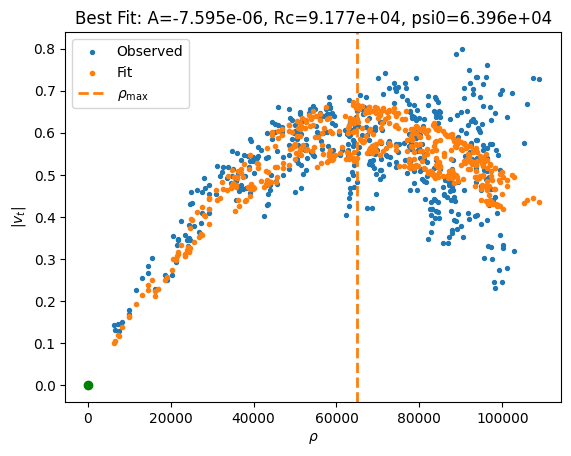

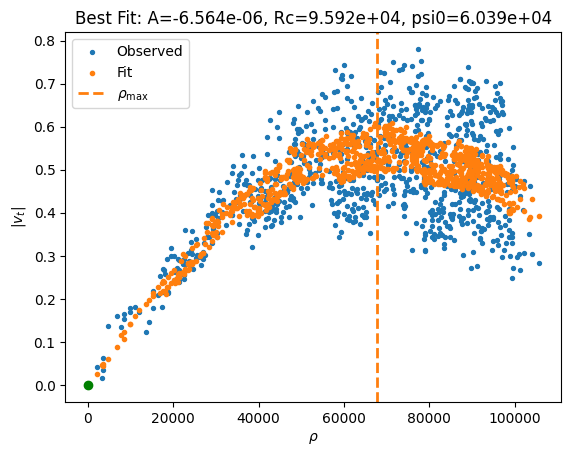

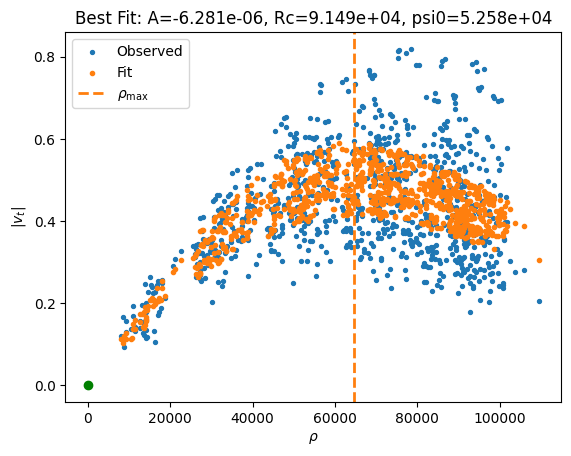

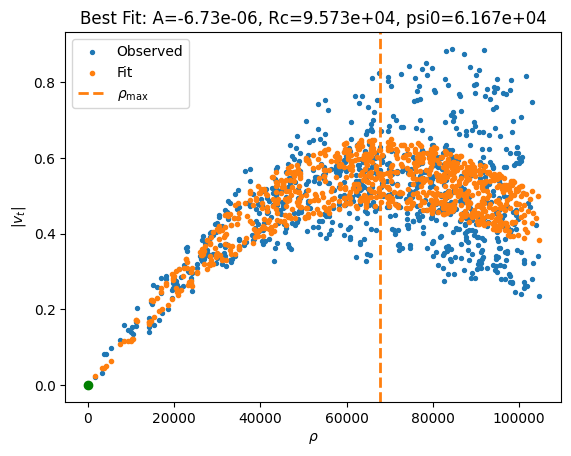

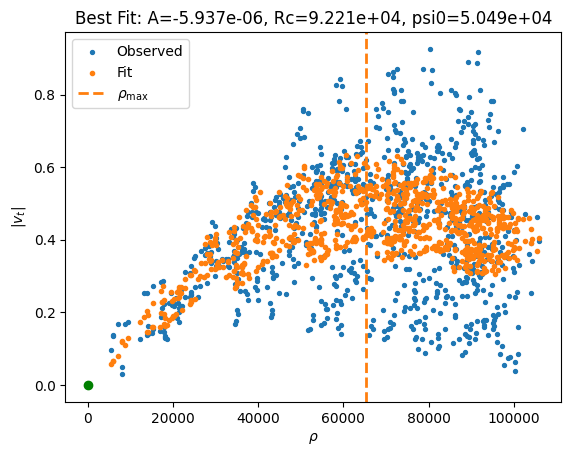

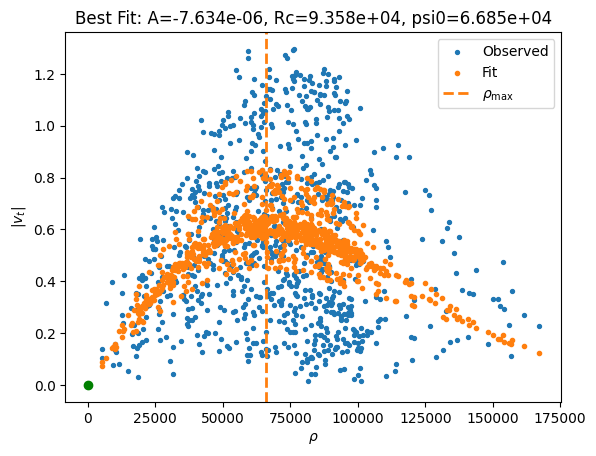

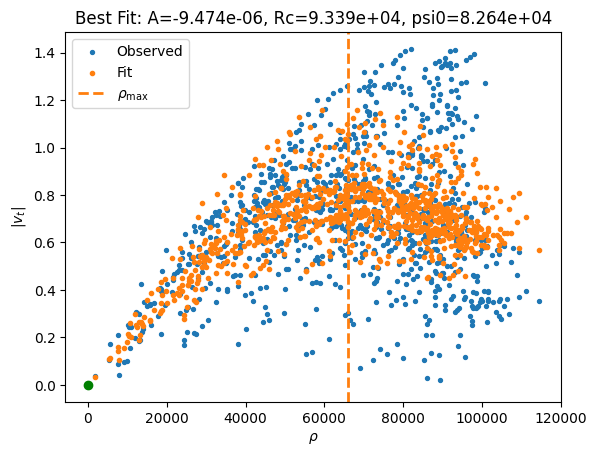

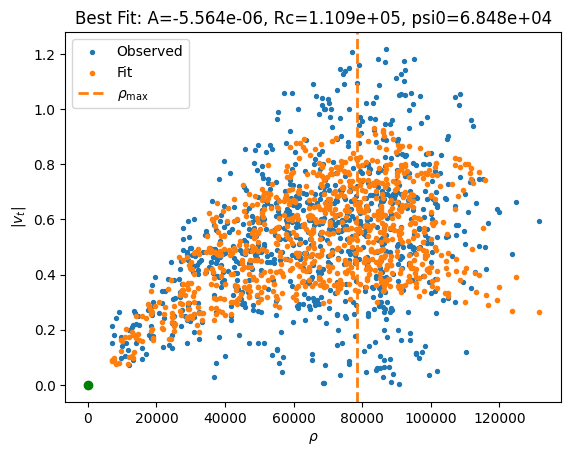

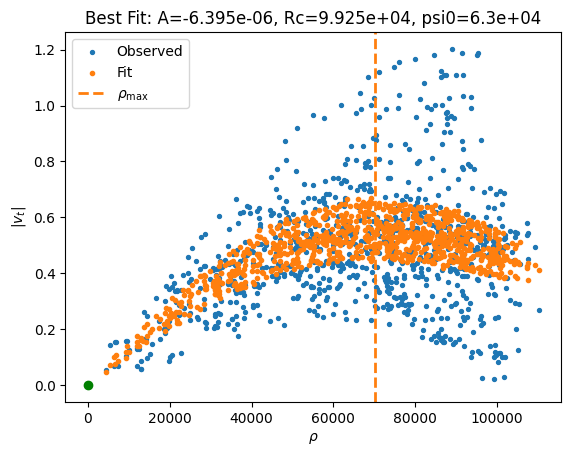

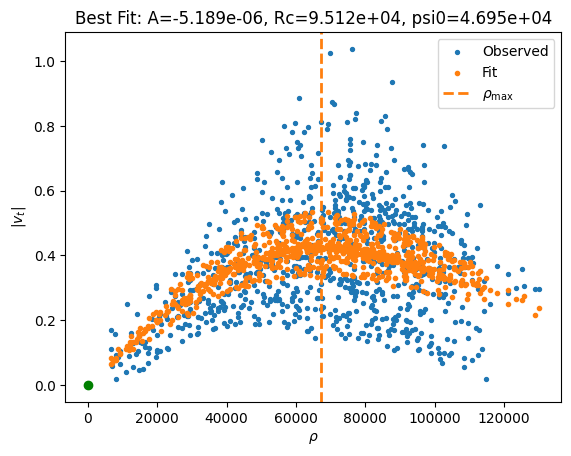

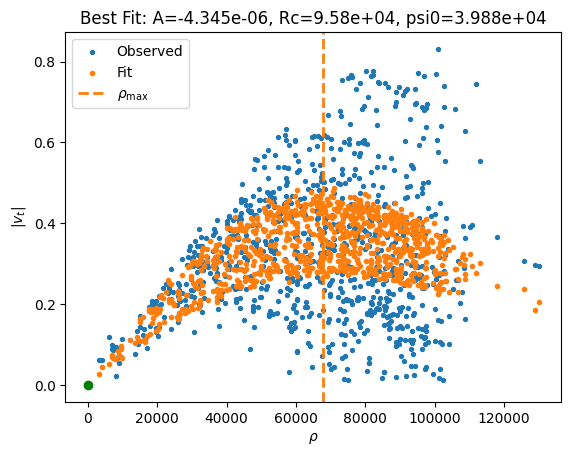

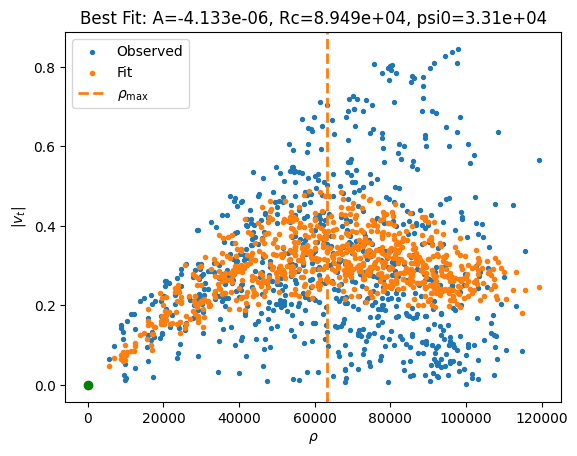

In [6]:
Rcs, psi0s, As = [], [], []
for k, time in enumerate(new_dfs.keys()):
    df = new_dfs[time].copy()
    df = df[df.vt <= 0]
    Rc_opt, psi0_opt, A_opt = fit_psi_params(df.rho2, df.Qr, df.vt, plot=True if k%10==0 else False, Rc_max=1e6) 
    Rcs.append(Rc_opt); psi0s.append(psi0_opt); As.append(A_opt)
df_res['Rc_opt'] = Rcs; df_res['psi0_opt'] = psi0s; df_res['A_opt'] = As


(np.float64(-345818.01056400995),
 np.float64(21371.732126693747),
 np.float64(-3818.7749864872903),
 np.float64(167943.0387510461))

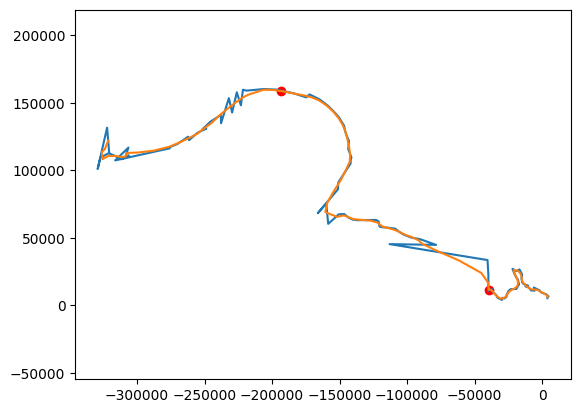

In [7]:
wdw = 3
df_res['sxc'] = smooth(df_res.xc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Time, window=wdw, num=len(df_res)) 

plt.plot(df_res.xc, df_res.yc)
plt.plot(df_res.sxc, df_res.syc)

for k in [44, 86]:
    data = df_res.iloc[k]
    plt.scatter(data.xc, data.yc, color='r')
plt.axis('equal')


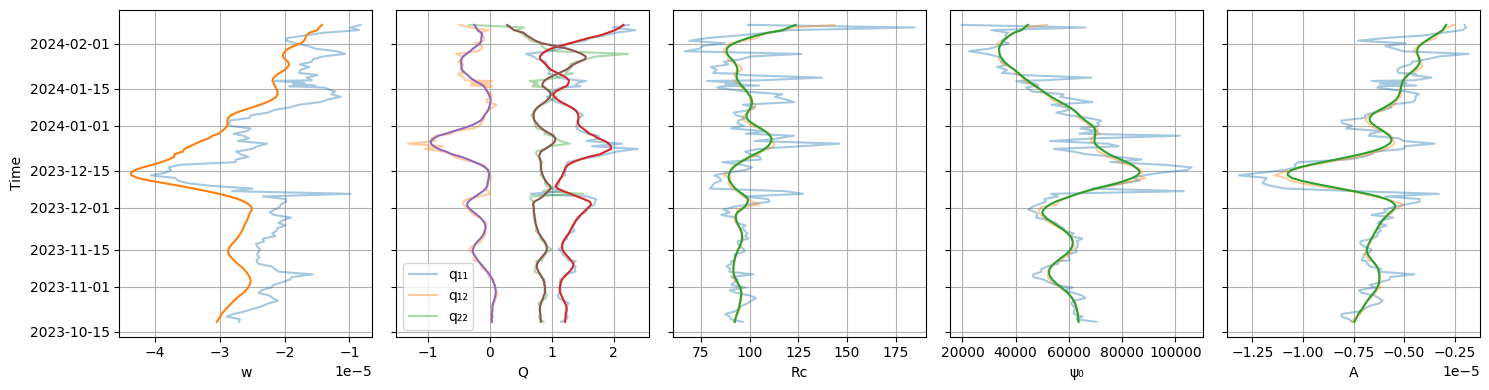

In [8]:
wdw = 6
# df_res['sw'] = smooth(df_res.w, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc_opt, df_res.Time, window=wdw, num=len(df_res)) 
# df_res['spsi0'] = smooth(df_res.psi0_opt, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A_opt, df_res.Time, window=wdw, num=len(df_res)) 

# Optimal 
df_res['sw'] = 2*df_res.sA*(df_res.sq11 + df_res.sq22)
df_res['spsi0'] = -df_res.sA*df_res.sRc**2

fig, axs = plt.subplots(1, 5, figsize=(15,4), sharey=True)
alpha = .4

axs[0].plot(df_res.w, df_res.Time, alpha=alpha)
axs[0].plot(df_res.sw, df_res.Time)
axs[0].set_xlabel('w')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, label='q₁₁', alpha=alpha)
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, label='q₁₂', alpha=alpha)
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, label='q₂₂', alpha=alpha)
axs[1].plot(df_res.sq11, df_res.Time)
axs[1].plot(df_res.sq12, df_res.Time)
axs[1].plot(df_res.sq22, df_res.Time)
axs[1].set_xlabel('Q')
axs[1].legend()

axs[2].plot(df_res.Rc/1000, df_res.Time, alpha=alpha)
axs[2].plot(df_res.Rc_opt/1000, df_res.Time, alpha=alpha)
axs[2].plot(df_res.sRc/1000, df_res.Time)
axs[2].set_xlabel('Rc')

axs[3].plot(df_res.psi0, df_res.Time, alpha=alpha)
axs[3].plot(df_res.psi0_opt, df_res.Time, alpha=alpha)
axs[3].plot(df_res.spsi0, df_res.Time)
axs[3].set_xlabel('ψ₀')

axs[4].plot(df_res.A, df_res.Time, alpha=alpha)
axs[4].plot(df_res.A_opt, df_res.Time, alpha=alpha)
axs[4].plot(df_res.sA, df_res.Time)
axs[4].set_xlabel('A')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Time')

plt.tight_layout()


In [9]:
X, Y = x_ssh, y_ssh

U = np.zeros((X.shape[0], X.shape[1], len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(df_res)))

for k in range(len(df_res)):
    data = df_res.iloc[k]
    dx, dy = X - data.sxc, Y - data.syc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2

    U[:,:,k] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
    V[:,:,k] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 


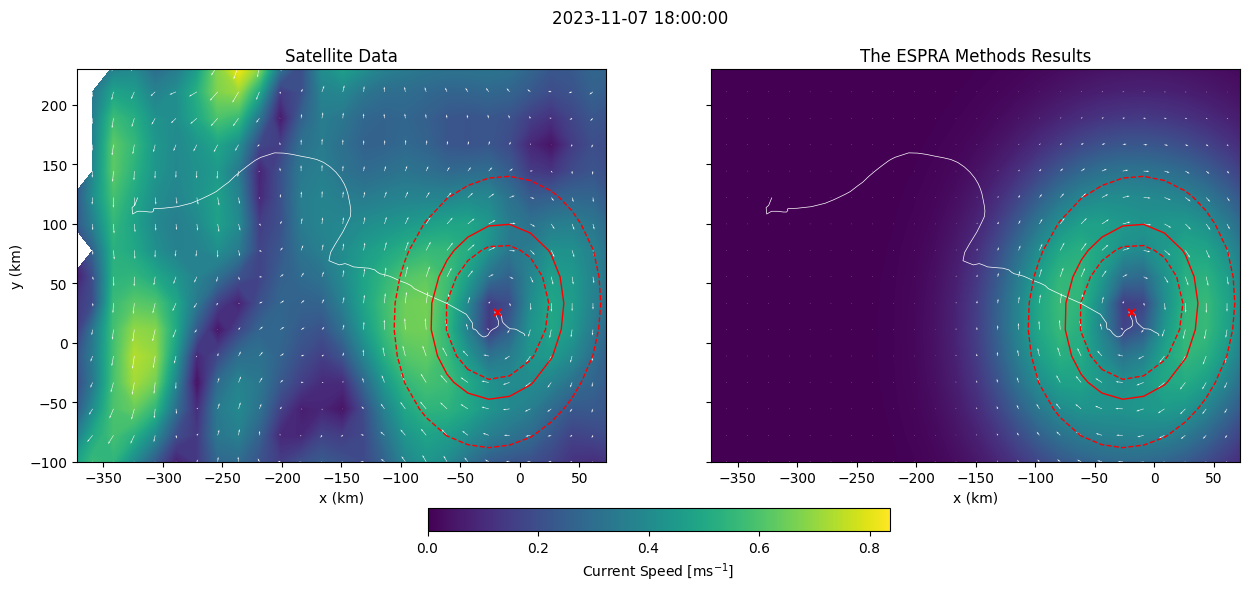

In [10]:
t_idx = 20
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

data = df_res.iloc[t_idx]

# data & masks
closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
spd1 = np.hypot(ut_mask, vt_mask)

u, v = U[:,:,t_idx], V[:,:,t_idx]
spd2 = np.hypot(u, v)

# shared colour scale: force 0 baseline, use combined max, and FIX levels
vmin = 0.0
vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
cmap = 'viridis'
levels = np.linspace(vmin, vmax, 256)  # identical bins for both
norm = plt.Normalize(vmin, vmax)

# --- plot 1 ---
cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
axs[0].quiver(x_ssh/1e3, y_ssh/1e3, ut_mask, vt_mask, width=.001, scale=30, color='w')
axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')

# --- plot 2 ---
cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
spac = 1
axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
              u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
               colors='r', zorder=3, linewidths=1, linestyles='--')
axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The ESPRA Methods Results')
axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)

# shared colourbar reflects exactly those shared levels
cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label(r'Current Speed [ms$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, round(vmax, 1), 5))
# plt.tight_layout()
fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
plt.show()


In [11]:
# # MOVIE
# for t_idx in range(len(df_res)):
#     fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
#     data = df_res.iloc[t_idx]
    
#     # data & masks
#     closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
#     ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
#     mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
#     ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
#     spd1 = np.hypot(ut_mask, vt_mask)
    
#     u, v = U[:,:,t_idx], V[:,:,t_idx]
#     spd2 = np.hypot(u, v)
    
#     # shared colour scale: force 0 baseline, use combined max, and FIX levels
#     vmin = 0.0
#     # vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
#     vmax = 1
#     cmap = 'viridis'
#     levels = np.linspace(vmin, vmax, 256)  # identical bins for both
#     norm = plt.Normalize(vmin, vmax)
    
#     # --- plot 1 ---
#     cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
#     axs[0].quiver(x_ssh/1e3, y_ssh/1e3, ut_mask, vt_mask, width=.001, scale=30, color='w')
#     axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
#     dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
#     rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
#     axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
#     axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')
    
#     # --- plot 2 ---
#     cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
#     spac = 1
#     axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
#                   u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
#     axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
#     axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(rho_outer_core_thresh/1e3)**2],
#                    colors='r', zorder=3, linewidths=1, linestyles='--')
#     axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The ESPRA Methods Results')
#     axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)
    
#     # shared colourbar reflects exactly those shared levels
#     cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
#     cbar.set_label(r'Current Speed [ms$^{-1}$]')
#     cbar.set_ticks(np.linspace(vmin, 1, 5))

#     fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
#     plt.savefig(f'/srv/scratch/z5297792/ESP_Paper_Data/ESPRA_IMOS_Data/tracking_images/frame_{t_idx:03d}.png', dpi=300, bbox_inches='tight')
#     plt.close()



In [12]:
df_res['Data'] = 'Satellite'
df_res['Method'] = 'ESPRA'
df_res


,xc,yc,w,Q,Rc,psi0,A,Time,Rc_opt,psi0_opt,...,syc,sq11,sq12,sq22,sRc,sA,sw,spsi0,Data,Method
0,3844.432520,5309.443027,-0.000027,"[[1.1501845463568723, 0.017300724757005077], [...",96434.814310,70322.726083,-0.000008,2023-10-18 18:00:00,91768.604190,63963.104434,...,6108.847627,1.214708,0.032133,0.825636,92313.419134,-0.000007,-0.000030,63606.641777,Satellite,ESPRA
1,4028.598606,6972.204595,-0.000027,"[[1.2378275192923252, 0.023327659822904585], [...",90258.113963,62897.012499,-0.000008,2023-10-19 18:00:00,92271.666141,63591.359567,...,6317.923491,1.221441,0.030642,0.820735,92665.809386,-0.000007,-0.000030,63466.889153,Satellite,ESPRA
2,4681.289277,6594.580785,-0.000029,"[[1.2612861582461656, 0.058724965753571515], [...",89716.678167,65168.617495,-0.000008,2023-10-20 18:00:00,92973.308062,63194.991786,...,7260.060696,1.223322,0.032200,0.819321,93033.517612,-0.000007,-0.000030,63421.672109,Satellite,ESPRA
3,2739.151927,8319.650798,-0.000028,"[[1.2387353809526243, 0.021655792499544215], [...",87457.815245,61838.754880,-0.000008,2023-10-21 18:00:00,93756.300524,62985.662684,...,7849.280168,1.225808,0.034072,0.817550,93386.517651,-0.000007,-0.000030,63386.929376,Satellite,ESPRA
4,1703.742792,8538.064814,-0.000026,"[[1.2294191619263521, 0.040962834132780054], [...",92502.971439,61828.368613,-0.000007,2023-10-22 18:00:00,94556.723363,63205.411991,...,8661.191037,1.239874,0.036693,0.807852,93882.487129,-0.000007,-0.000029,63151.908910,Satellite,ESPRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,-320982.739683,112616.982190,-0.000017,"[[1.86289582305675, -0.14197917492743228], [-0...",94656.890187,36040.314040,-0.000004,2024-02-04 06:00:00,105209.743433,37587.343752,...,110547.871773,1.780906,-0.124675,0.595918,103840.774805,-0.000004,-0.000017,37747.419526,Satellite,ESPRA
114,-327113.425541,109345.437259,-0.000014,"[[2.035480441554206, -0.15444816339197331], [-...",109173.915901,37140.121616,-0.000003,2024-02-05 06:00:00,109826.700657,39322.798619,...,108233.319007,1.907524,-0.138347,0.545029,109246.244208,-0.000003,-0.000016,39362.371957,Satellite,ESPRA
115,-329127.567714,100920.448426,-0.000008,"[[2.3533676994610513, -0.024034089676106093], ...",120450.863992,30870.552921,-0.000002,2024-02-06 06:00:00,117020.158008,41818.074588,...,113653.206053,2.025850,-0.201217,0.389167,116842.647726,-0.000003,-0.000015,42226.008464,Satellite,ESPRA
116,-322125.926819,131527.067491,-0.000010,"[[1.9886299490910664, -0.3108610148420783], [-...",184710.677799,66194.839429,-0.000002,2024-02-07 06:00:00,122223.602056,43205.503473,...,115569.549178,2.104488,-0.227434,0.332092,120018.974822,-0.000003,-0.000015,43377.702662,Satellite,ESPRA


In [13]:
df_res.to_pickle("/srv/scratch/z5297792/ESP_Paper_Data/df_res_satellite_ESPRA.pkl")
